# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from start
read_post_muncipalities  read from file
read_stats_postcode  read from file
read_ravintolat_ja_kaupat  read from file
read_kiinteisto  read from file
read_vaalit  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=False)

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd

from draw_and_create_clusters import create_kmeans_clusters 

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data

from draw_and_create_clusters import draw_pca, drawTSNE,  display_scree_plot, display_circles, display_parallel_coordinates_centroids, display_factorial_planes
from delete_outliers import delete_outliers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load the TensorBoard notebook extension
%load_ext tensorboard

pd.options.display.max_colwidth = 100


selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

selected = stat[(stat['muncipality_code']==49)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==49)].copy()
post_included = post[post['muncipality_code']==49]['postcode'].copy()


selected = stat[(stat['muncipality_code']==91)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91)].copy()
post_included = post[post['muncipality_code']==91]['postcode'].copy()

selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[vaalidata['area_code']=='FI1B1'].copy()
post_included = post[post['area_code']=='FI1B1'].copy()

selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

In [5]:
from create_target_columns import create_target_columns
from create_neuro_prediction import create_neuro_prediction
list_of_parties = ['VIHR', 'KOK', 'SDP', 'KD', 'KESK', 'RKP', 'PS', 'VAS']

target_col_start = 'Äänet yhteensä lkm'
target = create_target_columns(list_of_parties, target_col_start)


In [6]:
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from create_prediction import create_prediction


#set values to feature engineering attributes

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'
test_size = 0.3
#Scalers attributes
kbest_score_func = mutual_info_regression 

metric = 'rmse'
Skfold=False
Verbose = False
testing=True
scaled = True



In [7]:
from prepare_and_scale_data import prepare_and_scale_data
from draw_all import draw_true_vs_predicted
from shap_tree import shap_tree
from shap_vals import shap_vals
import matplotlib.pyplot as plt

sh_dict = {} 
sh_interaction_dict = {}
sh_expected_dict = {}
sh_vals = {}
mod_dict = {}
features_dict =  {}
importance_dict = {}
data, X, X_scale = prepare_and_scale_data(selected, pd.DataFrame(), numeric_features=numeric_features, categorical_features=categorical_features)

i = 0
for t in target:
    params = {
        #Initial xgboost parameters to be automatically tuned
        'objective':'reg:squarederror',
        'booster' : 'gbtree',
        'eval_metric' : metric
        }
    d = pd.DataFrame()
    test = pd.DataFrame()
    print(t)
    d, test, features_df, importance_df, model, params, dtest, X_train, y_train, X_test, y_test = create_prediction(selected,
                          selected,
                          t,
                          kbest_score_func=kbest_score_func,
                          metric=metric,
                          params= params,
                          numeric_features=numeric_features,
                          categorical_features=categorical_features,
                          scaled=scaled,
                          k_selected = k_selected,
                          test_size = test_size,
                          Skfold=Skfold,
                          Verbose = Verbose,
                          testing=testing)

    data.loc[:,"Ennustettu "+ t] = d["Ennustettu "+ t]
    
    
    explainer, shap_values, shap_interaction_values, shap_expected_value  = shap_tree(X, data[t], params)
    k1 = shap_values
    k2 = shap_vals(X, shap_values)
    k3 = shap_interaction_values
    k4 = shap_expected_value
    sh_vals[t] = k1
    sh_dict[t] = k2
    sh_interaction_dict[t] = k3
    sh_expected_dict[t] = k4
    features_dict[t] = features_df
    importance_dict[t] = importance_df
    mod_dict[t] = model 


Äänet yhteensä lkm VIHR
[0]	train-rmse:245.26936	test-rmse:266.79825
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[41]	train-rmse:7.46882	test-rmse:148.30778

testing
Start with xgb.cv params: rmse: 189.25639333333334
Best xgb.cv params: max_depth 7, min_child_weight 3, rmse: 181.09368399999997
Best xgb.cv params: gamma 0.0, rmse: 181.09368399999997
Best xgb.cv params: lambda 0.8, alpha 0.4, rmse: 177.87110900000002
Best xgb.cv params: colsample_bytree 0.2, subsample 1.0, rmse: 171.38893099999999
Best xgb.cv params: eta 0.2, rmse: 167.842936
Best xgb.cv params: scale_pos_weight 0.0, rmse: 167.67440766666667
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.0, 'lambda': 0.8, 'alpha': 0.4, 'colsample_bytree': 0.2, 'subsample': 1.0, 'eta': 0.2, 'scale_po

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Äänet yhteensä lkm KOK
[0]	train-rmse:331.52356	test-rmse:270.38434
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[5]	train-rmse:114.41852	test-rmse:168.33714

testing
Start with xgb.cv params: rmse: 207.89363600000001
Best xgb.cv params: max_depth 6, min_child_weight 1, rmse: 207.89363600000001
Best xgb.cv params: gamma 1.4, rmse: 207.60997533333332
Best xgb.cv params: lambda 1.0, alpha 0.8, rmse: 206.65288766666666
Best xgb.cv params: colsample_bytree 0.4, subsample 1.0, rmse: 205.67693066666666
Best xgb.cv params: eta 0.2, rmse: 204.9207253333333
Best xgb.cv params: scale_pos_weight 0.0, rmse: 203.25944533333333
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 1, 'gamma': 1.4, 'lambda': 1.0, 'alpha': 0.8, 'colsample_bytree': 0.4, 'subsample': 1.0, 'eta': 0.2, 's

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Äänet yhteensä lkm SDP
[0]	train-rmse:292.32550	test-rmse:278.87085
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[13]	train-rmse:49.89099	test-rmse:158.10941

testing
Start with xgb.cv params: rmse: 185.179184
Best xgb.cv params: max_depth 3, min_child_weight 1, rmse: 179.022166
Best xgb.cv params: gamma 0.0, rmse: 179.022166
Best xgb.cv params: lambda 1.0, alpha 1.0, rmse: 177.627304
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 177.627304
Best xgb.cv params: eta 0.2, rmse: 180.29302966666668
Best xgb.cv params: scale_pos_weight 0.6, rmse: 178.037603
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 1.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.2, 'scale_pos_weight': 0.6}

[0]	train-rmse:328.6376

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Äänet yhteensä lkm KD
[0]	train-rmse:69.84727	test-rmse:62.19843
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[15]	train-rmse:13.95279	test-rmse:47.40138

testing
Start with xgb.cv params: rmse: 55.19037133333333
Best xgb.cv params: max_depth 2, min_child_weight 4, rmse: 53.46669133333334
Best xgb.cv params: gamma 0.0, rmse: 53.46669133333334
Best xgb.cv params: lambda 0.6, alpha 1.0, rmse: 53.118796
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 53.118796
Best xgb.cv params: eta 0.2, rmse: 53.44839466666667
Best xgb.cv params: scale_pos_weight 0.8, rmse: 53.25239066666666
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 2, 'min_child_weight': 4, 'gamma': 0.0, 'lambda': 0.6, 'alpha': 1.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.2, 'scale_pos_weight': 0.8}

[0

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Äänet yhteensä lkm KESK
[0]	train-rmse:192.95331	test-rmse:210.54201
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[21]	train-rmse:24.57142	test-rmse:139.40587

testing
Start with xgb.cv params: rmse: 125.74025466666667
Best xgb.cv params: max_depth 5, min_child_weight 1, rmse: 121.765821
Best xgb.cv params: gamma 0.0, rmse: 121.765821
Best xgb.cv params: lambda 1.0, alpha 0.0, rmse: 121.765821
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 121.765821
Best xgb.cv params: eta 0.2, rmse: 126.31481933333333
Best xgb.cv params: scale_pos_weight 0.0, rmse: 121.18750533333332
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.2, 'scale_pos_weight': 0.0}

[0]	tr

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Äänet yhteensä lkm RKP
[0]	train-rmse:171.71104	test-rmse:102.33630
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[3]	train-rmse:88.33633	test-rmse:91.29364

testing
Start with xgb.cv params: rmse: 166.580124
Best xgb.cv params: max_depth 6, min_child_weight 4, rmse: 164.1270956666667
Best xgb.cv params: gamma 1.8, rmse: 164.122762
Best xgb.cv params: lambda 1.0, alpha 0.4, rmse: 163.46455366666666
Best xgb.cv params: colsample_bytree 0.4, subsample 1.0, rmse: 160.01748666666666
Best xgb.cv params: eta 0.2, rmse: 154.9942576666667
Best xgb.cv params: scale_pos_weight 0.0, rmse: 153.71843966666668
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 4, 'gamma': 1.8, 'lambda': 1.0, 'alpha': 0.4, 'colsample_bytree': 0.4, 'subsample': 1.0, 'eta': 0.2, 'scale_pos_weight': 0

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Äänet yhteensä lkm PS
[0]	train-rmse:252.79129	test-rmse:243.96468
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[56]	train-rmse:8.64982	test-rmse:133.31076

testing
Start with xgb.cv params: rmse: 149.0972186666667
Best xgb.cv params: max_depth 4, min_child_weight 2, rmse: 142.235148
Best xgb.cv params: gamma 0.0, rmse: 142.235148
Best xgb.cv params: lambda 1.0, alpha 0.0, rmse: 142.235148
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 142.235148
Best xgb.cv params: eta 0.2, rmse: 144.703766
Best xgb.cv params: scale_pos_weight 0.0, rmse: 141.73602300000002
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.2, 'scale_pos_weight': 0.0}

[0]	train-rmse:281

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Äänet yhteensä lkm VAS
[0]	train-rmse:160.45369	test-rmse:161.93565
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 10 rounds.
Stopping. Best iteration:
[51]	train-rmse:6.42531	test-rmse:117.03714

testing
Start with xgb.cv params: rmse: 129.5504073333333
Best xgb.cv params: max_depth 5, min_child_weight 1, rmse: 126.92852799999999
Best xgb.cv params: gamma 0.0, rmse: 126.92852799999999
Best xgb.cv params: lambda 1.0, alpha 0.0, rmse: 126.92852799999999
Best xgb.cv params: colsample_bytree 1.0, subsample 1.0, rmse: 126.92852799999999
Best xgb.cv params: eta 0.4, rmse: 127.04069533333335
Best xgb.cv params: scale_pos_weight 0.6, rmse: 126.90600066666667
Found hyperparameters with 1 rounds 
{'objective': 'reg:squarederror', 'booster': 'gbtree', 'eval_metric': 'rmse', 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.0, 'colsample_bytree': 1.0, 'subsample': 1.0, 'eta': 0.4, 'sc

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
invalid value encountered in true_divide
invalid value encountered in true_divide


Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

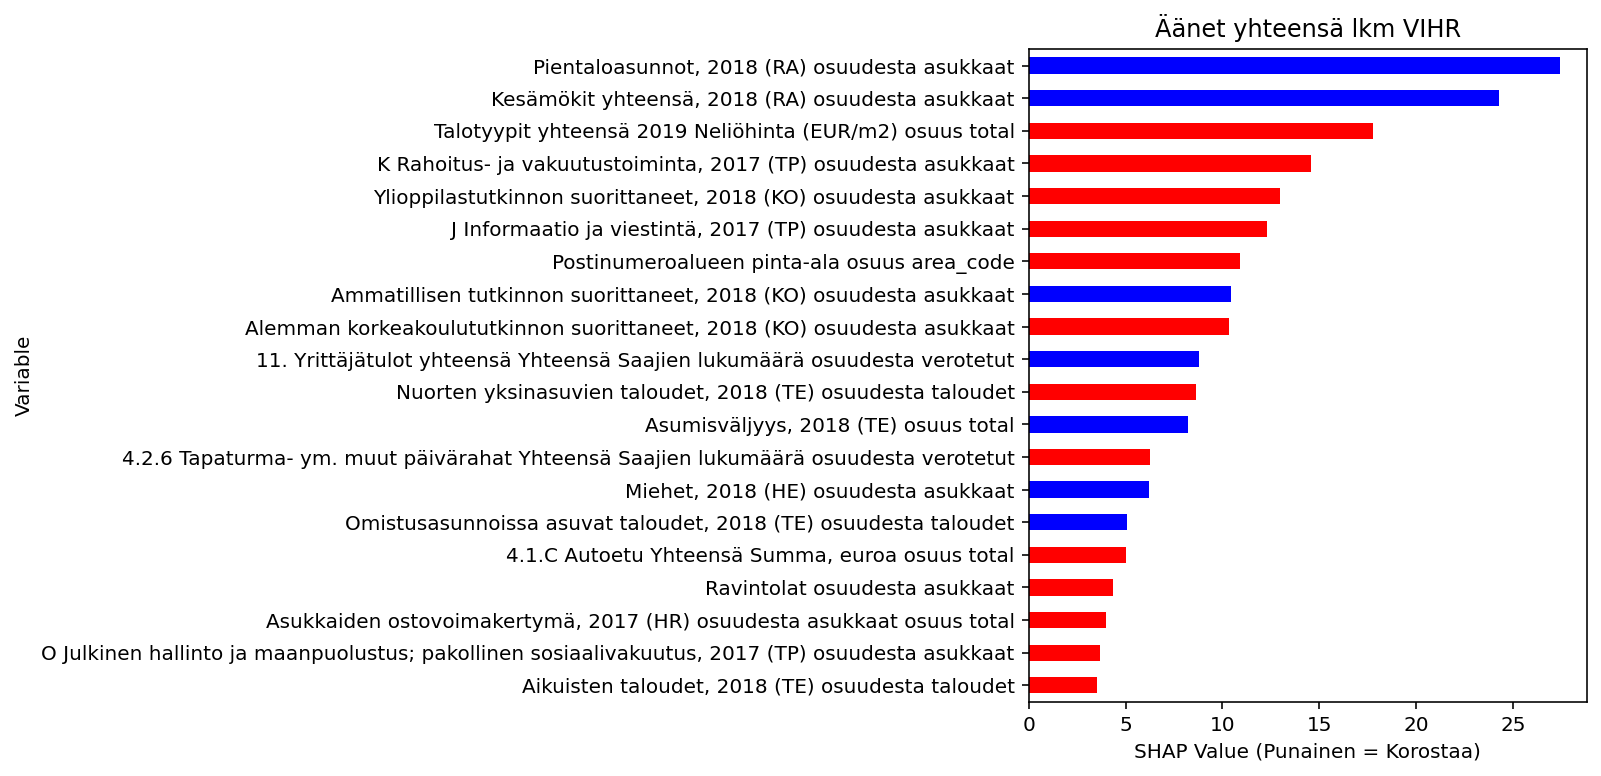

In [8]:
key = target[0]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

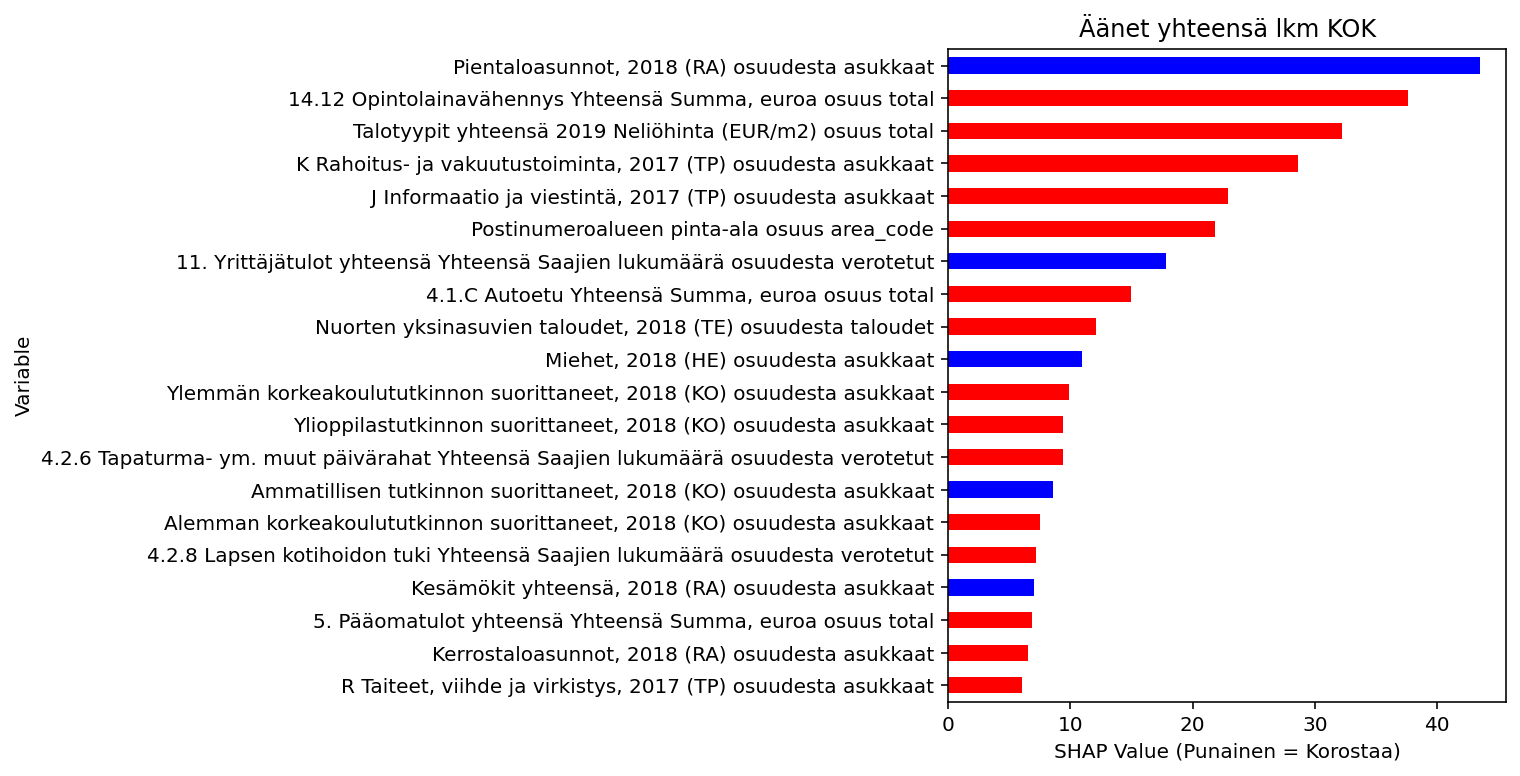

In [9]:
key = target[1]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

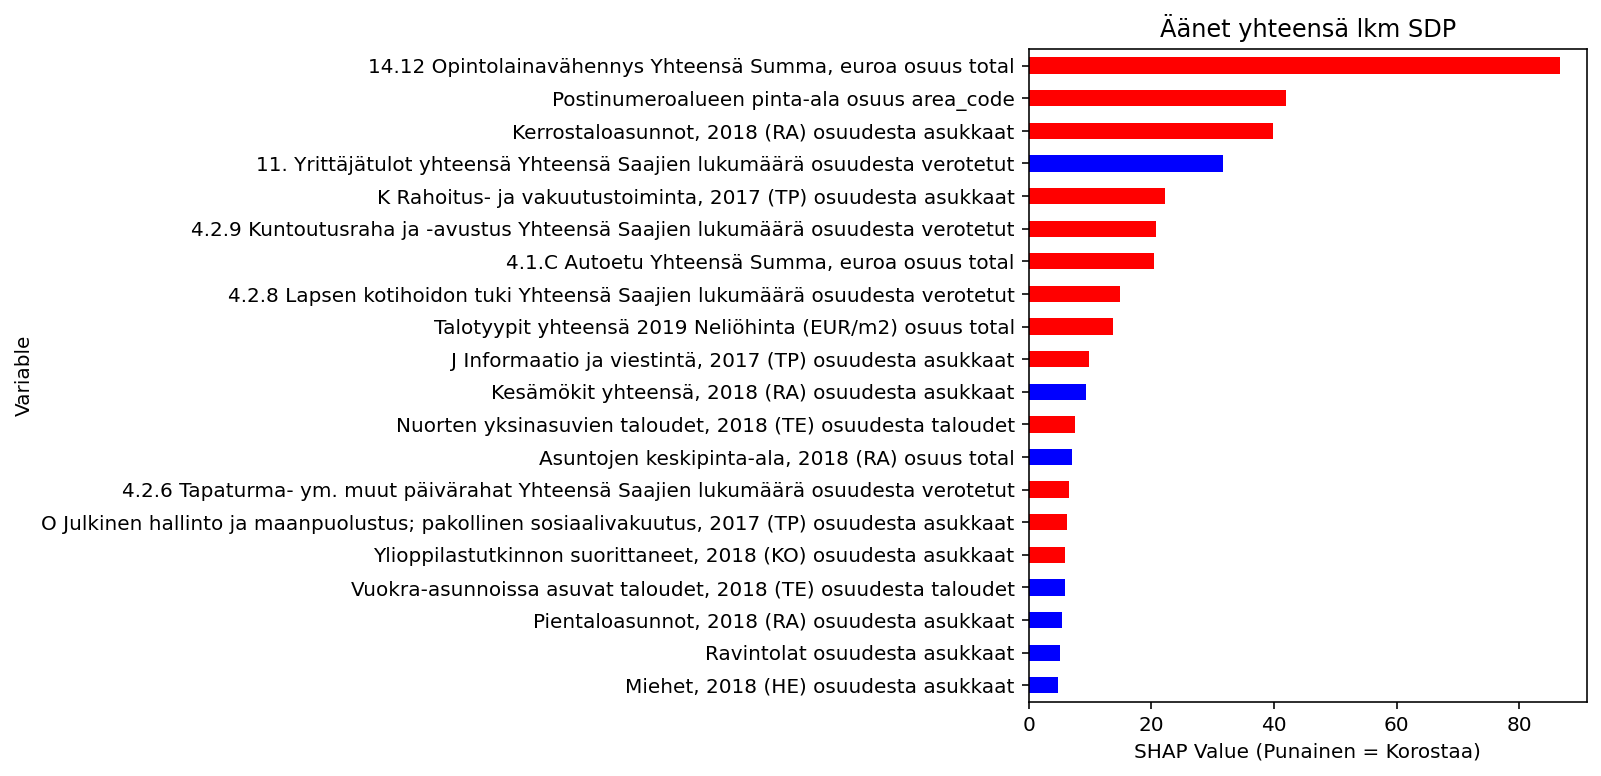

In [10]:
key = target[2]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

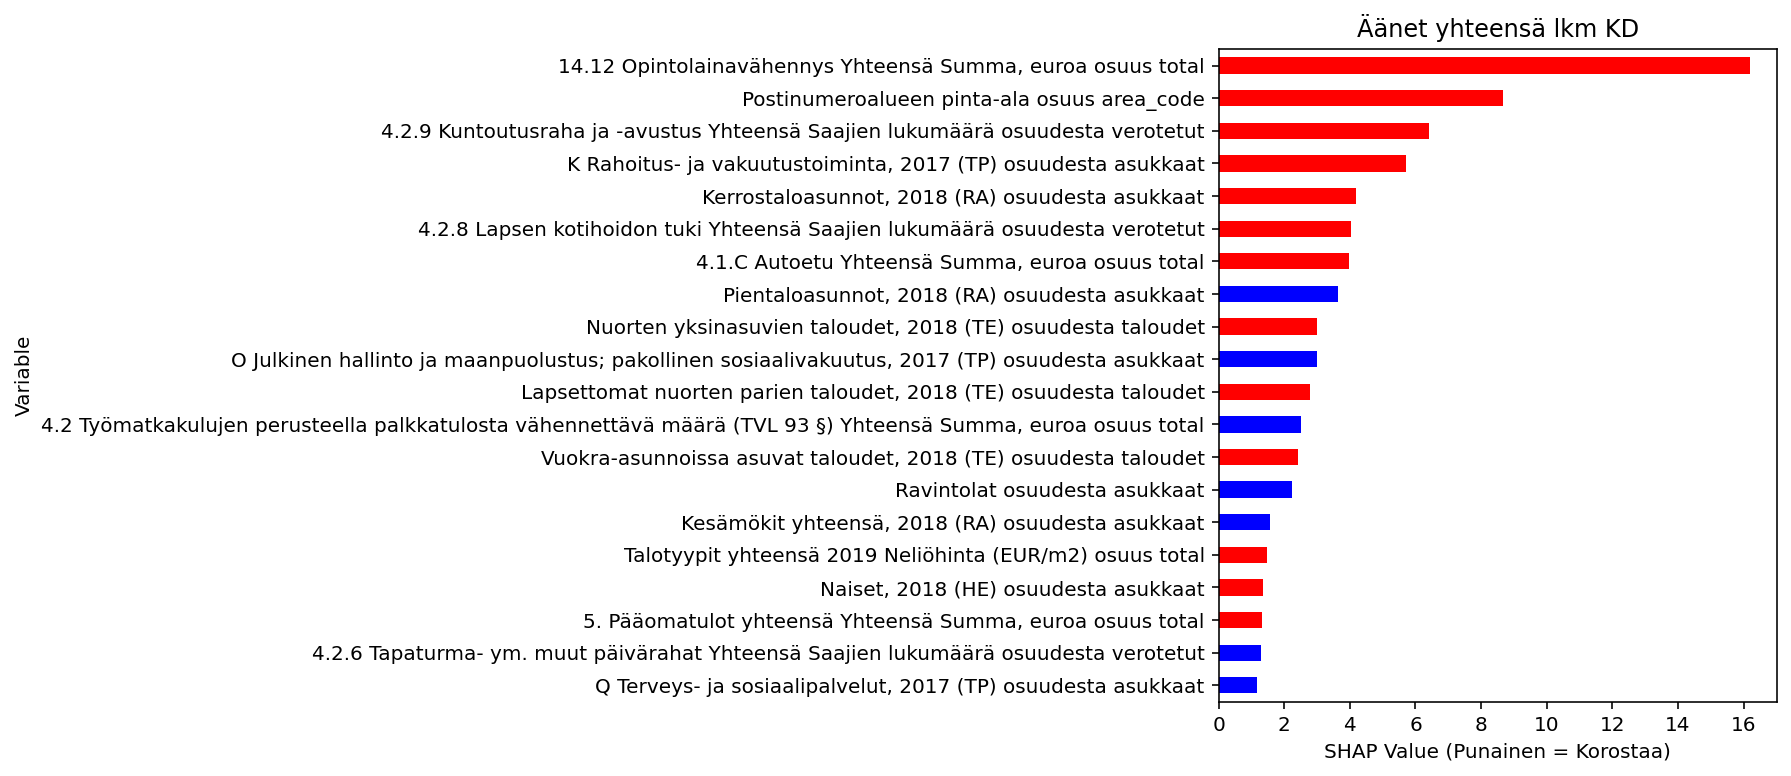

In [11]:
key = target[3]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

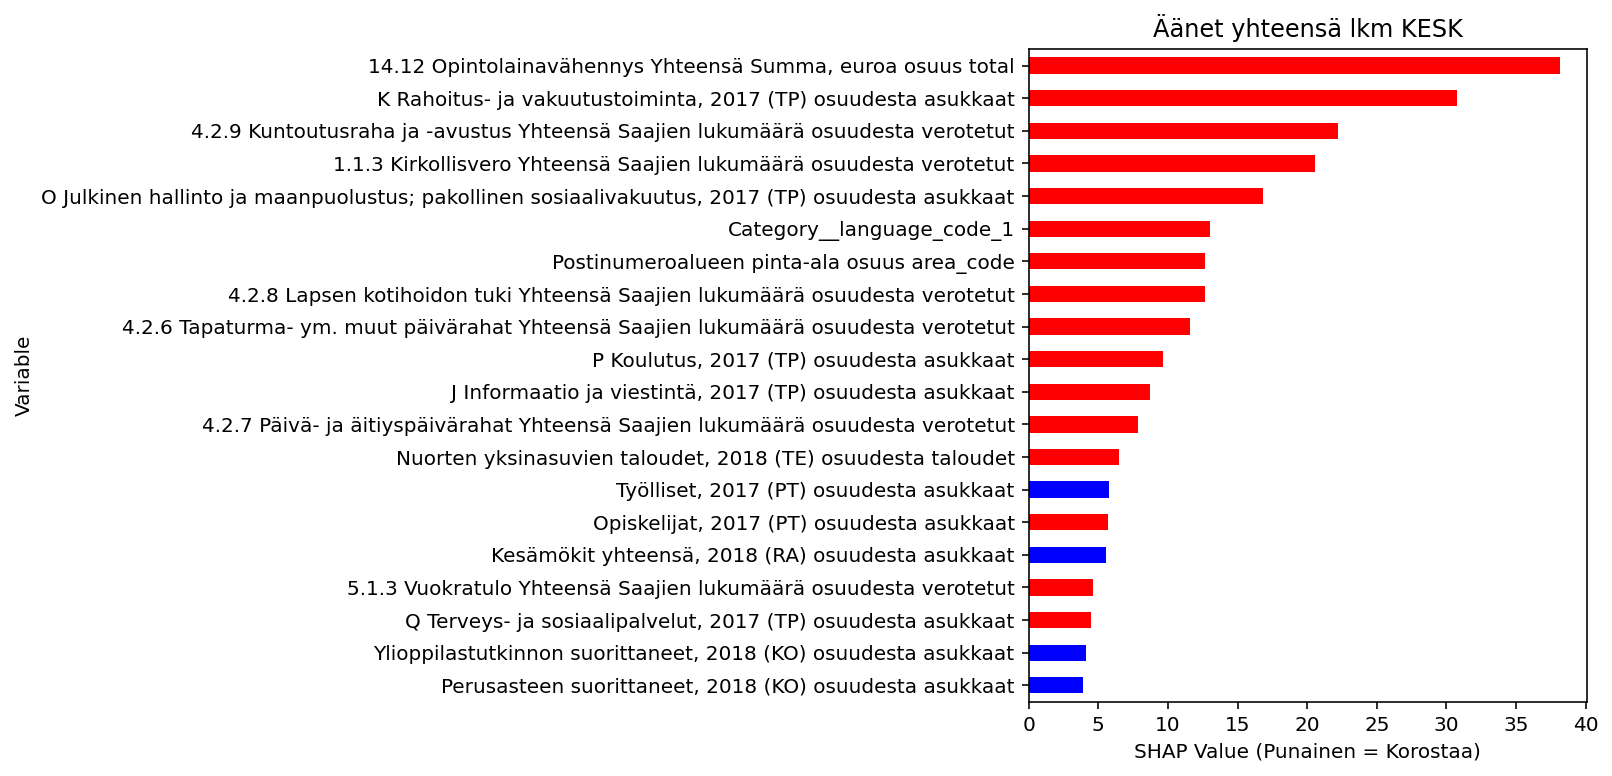

In [12]:
key = target[4]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

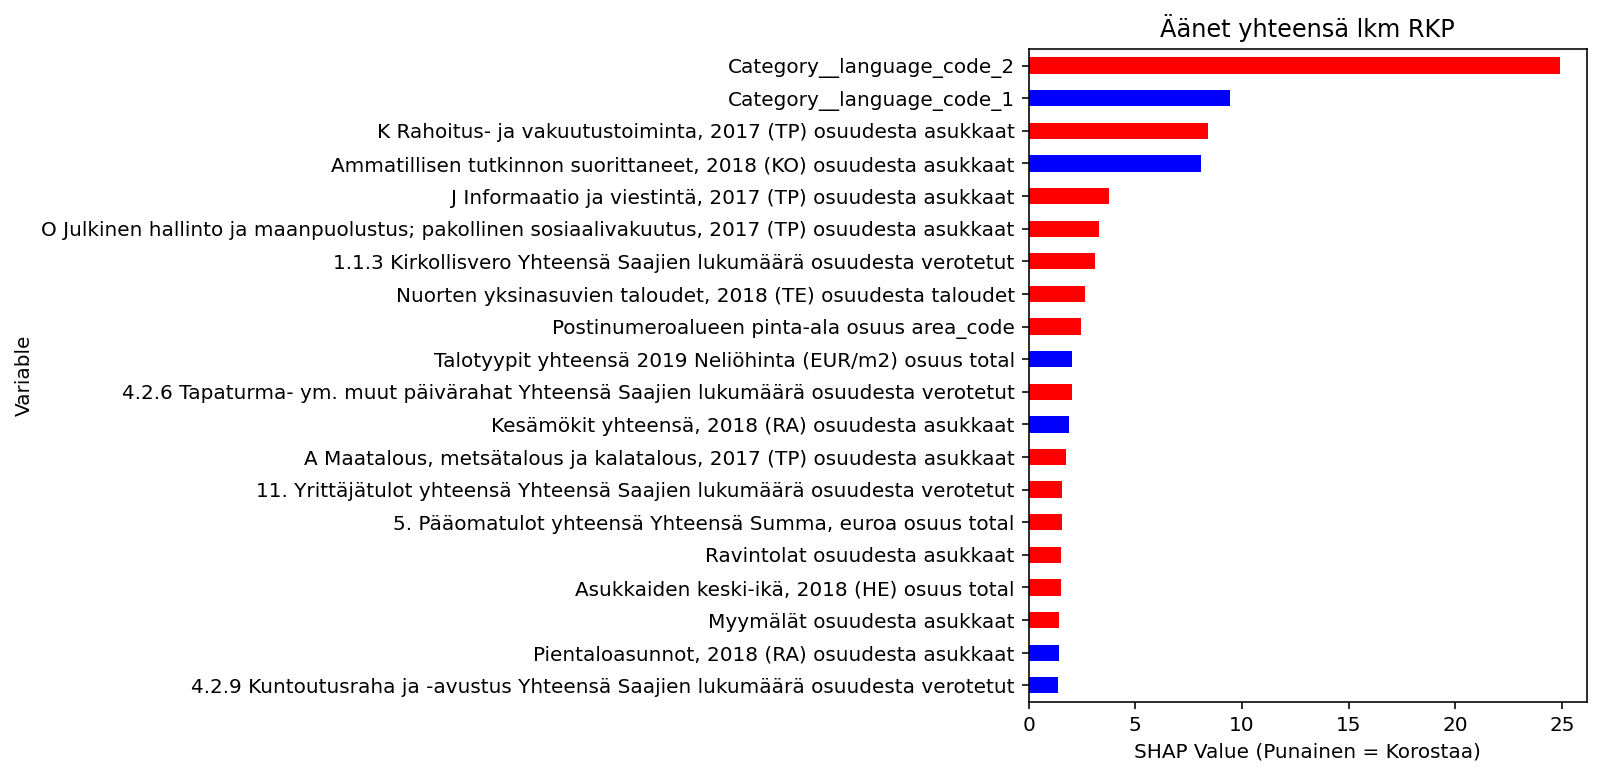

In [106]:
key = target[5]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

In [107]:
k2

,Variable,SHAP_abs,Corr,Sign
45,4.2.9 Kuntoutusraha ja -avustus Yhteensä Saajien lukumäärä osuudesta verotetut,1.381369,-0.271491,blue
16,"Pientaloasunnot, 2018 (RA) osuudesta asukkaat",1.399375,-0.308081,blue
28,Myymälät osuudesta asukkaat,1.421667,0.084865,red
5,"Asukkaiden keski-ikä, 2018 (HE) osuus total",1.500962,0.185753,red
27,Ravintolat osuudesta asukkaat,1.524953,0.176757,red
53,"5. Pääomatulot yhteensä Yhteensä Summa, euroa osuus total",1.548695,0.227979,red
41,11. Yrittäjätulot yhteensä Yhteensä Saajien lukumäärä osuudesta verotetut,1.569397,0.205593,red
20,"A Maatalous, metsätalous ja kalatalous, 2017 (TP) osuudesta asukkaat",1.748650,0.078028,red
15,"Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat",1.876166,-0.212887,blue
42,4.2.6 Tapaturma- ym. muut päivärahat Yhteensä Saajien lukumäärä osuudesta verotetut,2.031938,0.183564,red


Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

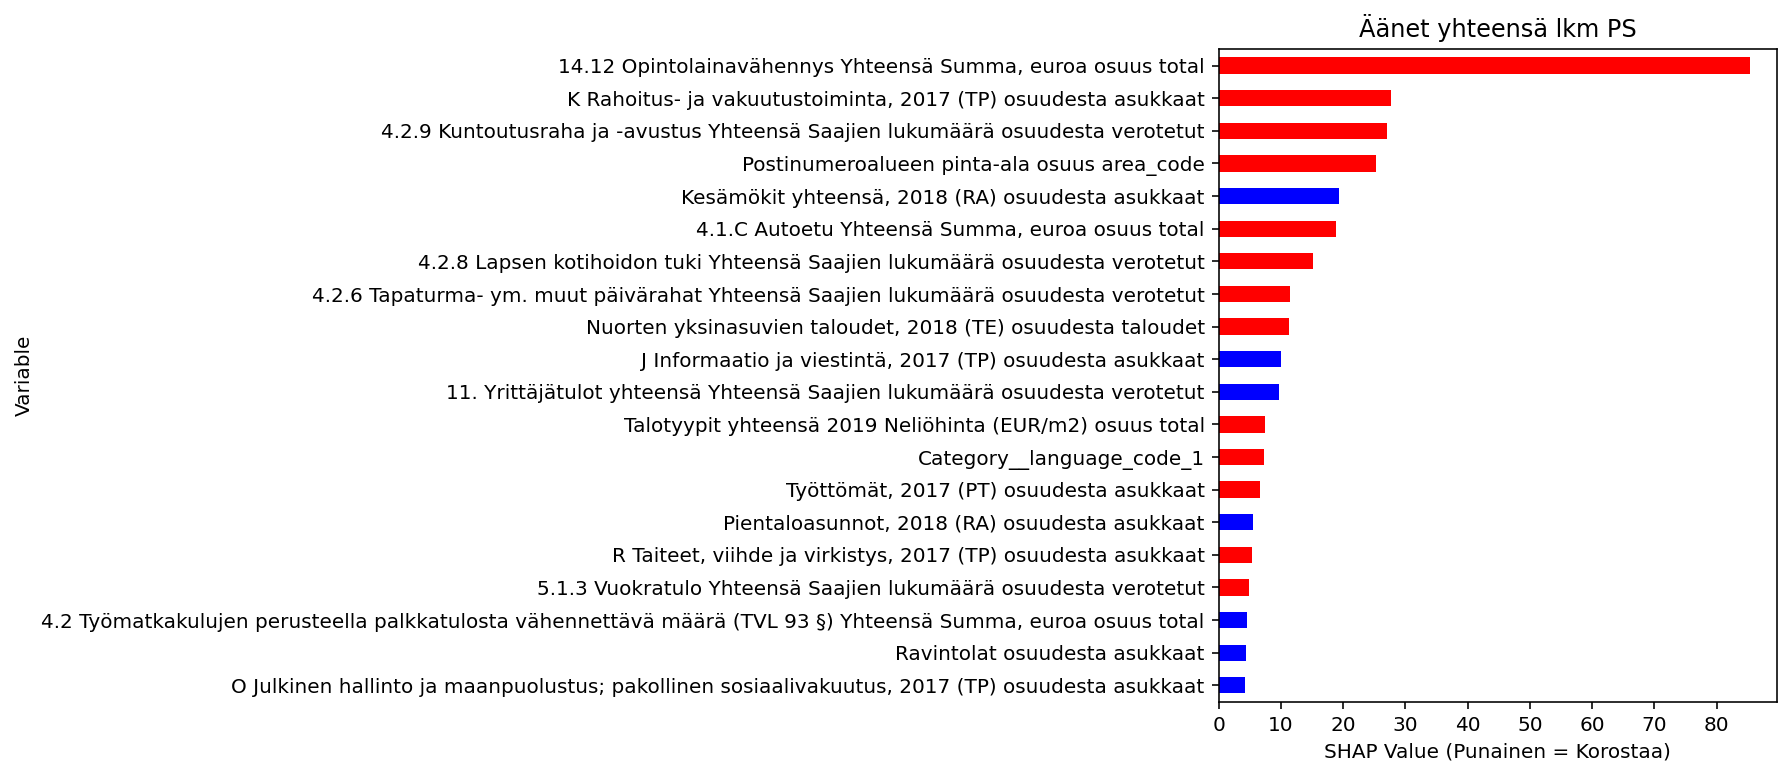

In [14]:
key = target[6]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

Text(0.5, 0, 'SHAP Value (Punainen = Korostaa)')

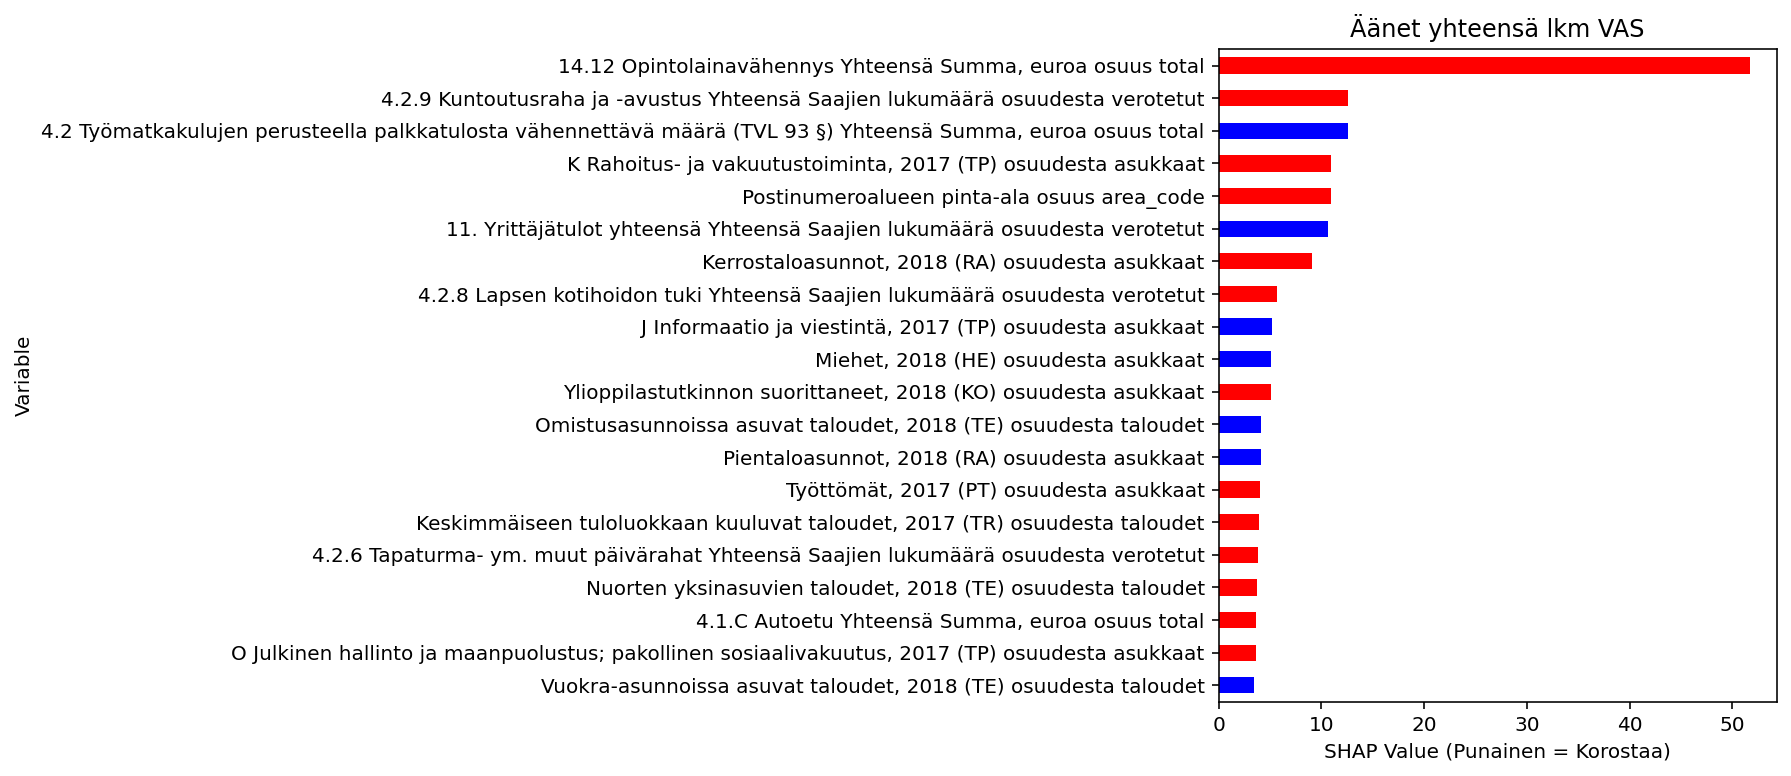

In [15]:
key = target[7]
k2 =sh_dict[key].tail(20)
colorlist = k2['Sign']
ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)
ax.set_xlabel("SHAP Value (Punainen = Korostaa)")

In [16]:
from show_election_result import show_election_result
show_election_result(data, selected_vaalidata, target_col_start, list_of_parties)

VIHR  lasketut äänet: Aitotulos  354152 Laskennallinen  344923 Ennuste  347606
Laskennallisen virhe aitoon tulokseen 2.606 %
Ennusteen virhe aitoon tulokseen 1.848 %
Ennusteen virhe laskennalliseen tulokseen -0.778 %

KOK  lasketut äänet: Aitotulos  523924 Laskennallinen  514725 Ennuste  517871
Laskennallisen virhe aitoon tulokseen 1.756 %
Ennusteen virhe aitoon tulokseen 1.155 %
Ennusteen virhe laskennalliseen tulokseen -0.611 %

SDP  lasketut äänet: Aitotulos  546263 Laskennallinen  538933 Ennuste  544119
Laskennallisen virhe aitoon tulokseen 1.342 %
Ennusteen virhe aitoon tulokseen 0.393 %
Ennusteen virhe laskennalliseen tulokseen -0.962 %

KD  lasketut äänet: Aitotulos  120019 Laskennallinen  117317 Ennuste  118871
Laskennallisen virhe aitoon tulokseen 2.251 %
Ennusteen virhe aitoon tulokseen 0.956 %
Ennusteen virhe laskennalliseen tulokseen -1.325 %

KESK  lasketut äänet: Aitotulos  423511 Laskennallinen  415357 Ennuste  413816
Laskennallisen virhe aitoon tulokseen 1.925 %
Ennuste

In [123]:
party ='KOK'
key = 'Äänet yhteensä lkm ' + party
pnro = '02160'

In [124]:
import numpy as np

individual = pd.DataFrame(pd.DataFrame(sh_vals[key], columns = X.columns).iloc[ix,:]).reset_index()
individual.columns=[pnro,'SHAP_abs']
individual.loc[:, 'Sign'] = np.where(individual['SHAP_abs']>=0,'red', 'blue')
individual.loc[:,'SHAP_abs'] = np.abs(individual['SHAP_abs'])
individual.sort_values('SHAP_abs', ascending=True, inplace=True, ignore_index=True)
colorlist = individual['Sign']

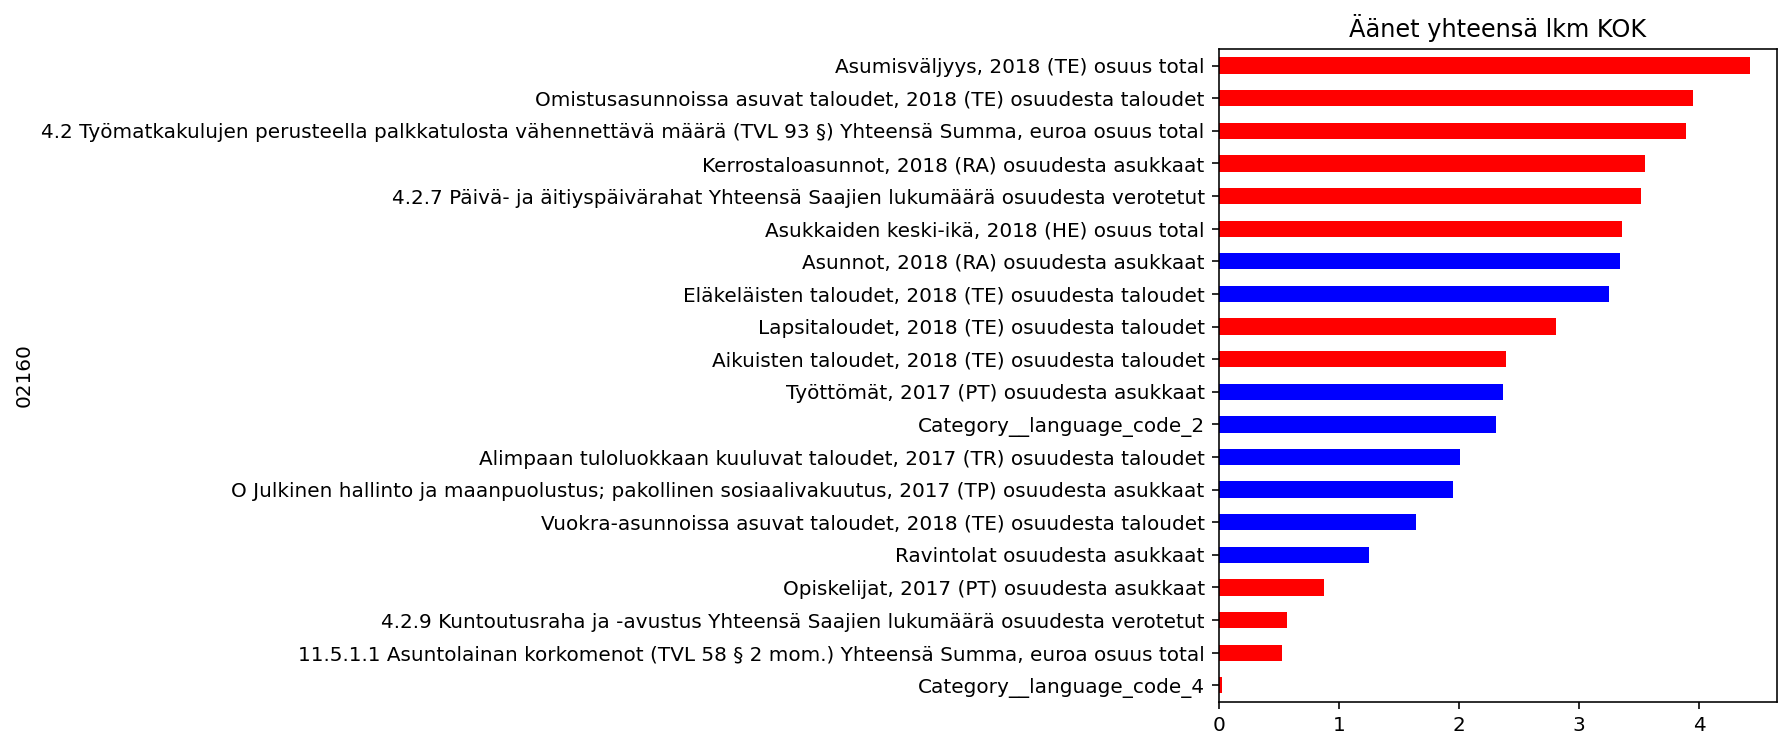

In [126]:
individual.head(20).plot.barh(x=pnro,y='SHAP_abs',color = colorlist, title= key, figsize=(5,6),legend=False)